# Ordered Logistic Regression

In [2]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
from numpyro import handlers
from numpyro.infer.reparam import TransformReparam

numpyro.set_host_device_count(4)
az.style.use("arviz-darkgrid")

In [47]:
df = (
    pd.read_csv("~/Downloads/kaggle_survey_2020_responses.csv", header=[1])
    .iloc[:, [4, 7, 8]]
    .copy()
)

df.columns = ["education", "python", "R"]
df["python"] = ~df["python"].isna()
df["R"] = ~df["R"].isna()
df = df[
    df["education"].isin(
        [
            "Doctoral degree",
            "Master’s degree",
            "Bachelor’s degree",
            "No formal education past high school",
        ]
    )
].reset_index(drop=True)
df['education'] = df['education'].replace('No formal education past high school', 'High school')

In [48]:
df

,education,python,R
0,Doctoral degree,True,True
1,Master’s degree,True,True
2,Bachelor’s degree,False,False
3,Master’s degree,True,False
4,Master’s degree,True,False
...,...,...,...
17374,Master’s degree,False,False
17375,Master’s degree,True,False
17376,Master’s degree,True,False
17377,Bachelor’s degree,True,False


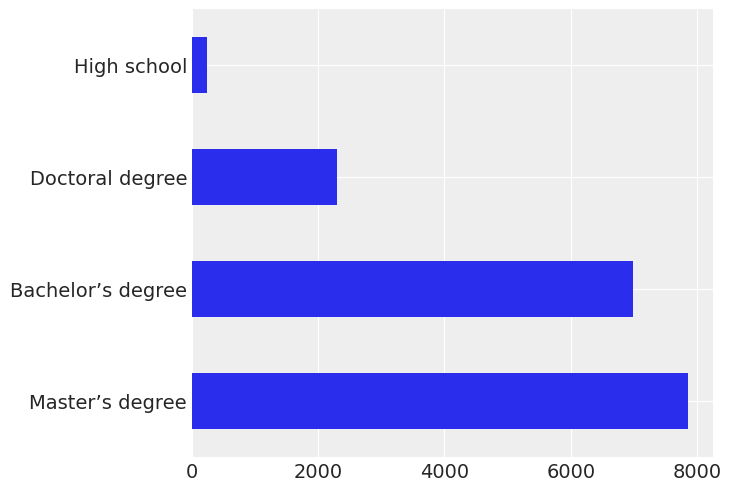

In [49]:
df['education'].value_counts().plot.barh();

In [78]:
education_to_index = {
    'High school': 0,
    'Bachelor’s degree': 1,
    'Master’s degree': 2,
    'Doctoral degree': 3,
}
index_to_education = {val: key for key, val in education_to_index.items()}

Is this your classic classification task?

### Train-test split

In [50]:
train = df.sample(frac=0.8).copy().reset_index(drop=True)
test = df.loc[~df.index.isin(train.index)].copy().reset_index(drop=True)

In [51]:
train.shape, test.shape

((13903, 3), (3476, 3))

## Categorical Distribution

In [52]:
dist.Categorical(probs=jnp.array([0.3, 0.4, 0.2, 0.1])).sample(
    jax.random.PRNGKey(8), sample_shape=(100,)
)

DeviceArray([1, 0, 0, 2, 1, 0, 0, 1, 1, 2, 0, 3, 1, 0, 0, 2, 1, 3, 3, 2,
             3, 0, 0, 2, 2, 0, 1, 0, 2, 0, 1, 2, 3, 1, 1, 0, 2, 2, 3, 1,
             0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 3, 1, 2, 2, 3, 1, 1, 1, 0, 1,
             1, 3, 1, 2, 0, 3, 2, 3, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2,
             1, 1, 0, 1, 1, 0, 0, 3, 1, 0, 2, 3, 2, 0, 2, 2, 3, 2, 0, 0],            dtype=int32)

## Back to our problem

Should be try predicting these probabilities directly?
Maybe not, maybe we need some additional structure to capture the ordering among them.

We started with probabilities of samples belonging to each class:

    p_0: probability of class 0
    p_1: probability of class 1
    p_2: probability of class 2

We then took cumulative probabilities:

    q_0: probability of class 0
    q_1: probability of class 1 or class 0
    q_2: probability of class 2 or class 1 or class 0
    
If we have `q`, then we can recover `p`:

    p_0 = q_0 - 0
    p_1 = q_1 - q_0
    p_2 = 1 - q_1

We can transform between `q` and `logits` as

    logit_0 = logit(q_0)
    logit_1 = logit(q_1)

Predict using our features

    prediction = coefficient_python*python + coefficient_R*R
    
We can then find our cutpoints

    cutpoint_0 = logit_0 + prediction
    cutpoint_1 = logit_1 + prediction

In [102]:
def ordered_logistic_regression(python, R, n_responses, response=None):
    coefficient_python = numpyro.sample(
        'coefficient_python',
        dist.Normal(0, 1),
    )
    coefficient_R = numpyro.sample(
        'coefficient_R',
        dist.Normal(0, 1),
    ) 
    cutpoints = numpyro.sample(
        'cutpoints',
        dist.TransformedDistribution(
            dist.Normal(0, 1.5).expand([n_responses-1]),
            dist.transforms.OrderedTransform(),
        )
    )

    prediction = coefficient_python*python + coefficient_R*R
    logits = cutpoints - prediction[:, jnp.newaxis]
    cumulative_probs = jnp.pad(
        jax.scipy.special.expit(logits),
        pad_width=((0, 0), (1, 1)),
        constant_values=(0, 1),
    )
    probs = numpyro.deterministic("probs", jnp.diff(cumulative_probs))

    numpyro.sample(
        "response",
        dist.Categorical(probs=probs),
        obs=response,
    )

## Prior predictive simulation

In [103]:
prior_pred = numpyro.infer.Predictive(ordered_logistic_regression, num_samples=100)
hours_worked_scaled = np.linspace(-3, 3, num=100)
prior_predictions = prior_pred(
    jax.random.PRNGKey(93),
    python=np.array([0, 0, 1, 1]),
    R=np.array([0, 1, 0, 1]),
    n_responses=4,
)

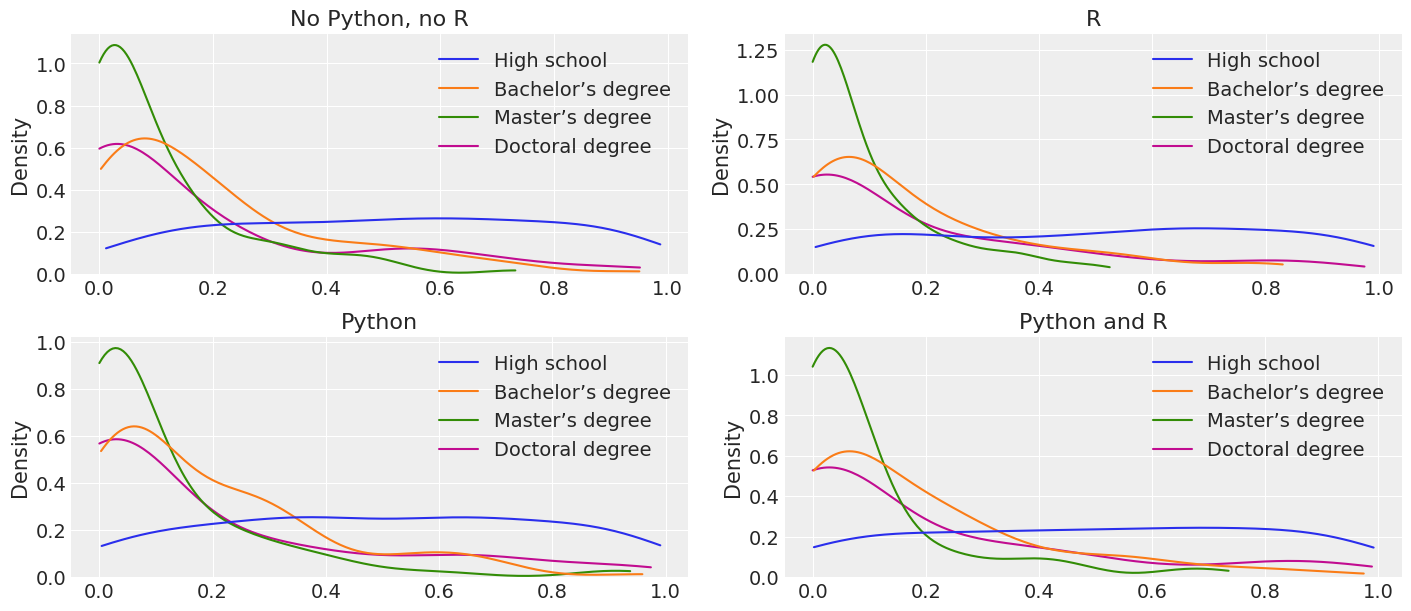

In [104]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))
ax = ax.flatten()
rows = {
    0: 'No Python, no R',
    1: 'R',
    2: 'Python',
    3: 'Python and R',
}

for row, description in rows.items():
    prior_df = pd.DataFrame(prior_predictions['probs'][:, row, :], columns=education_to_index)
    sns.kdeplot(data=prior_df, ax=ax[row], cut=0);
    ax[row].set_title(description)

## MCMC

In [106]:
sampler = numpyro.infer.NUTS(ordered_logistic_regression)
mcmc = numpyro.infer.MCMC(sampler, num_chains=4, num_samples=1000, num_warmup=1000)
mcmc.run(
    jax.random.PRNGKey(93),
    python=train['python'].to_numpy(),
    R=train['R'].to_numpy(),
    n_responses=4,
    response=train['education'].map(education_to_index).to_numpy(),
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [107]:
mcmc.print_summary()


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
       coefficient_R      0.69      0.04      0.69      0.62      0.75   2966.14      1.00
  coefficient_python      0.03      0.04      0.03     -0.03      0.10   3289.85      1.00
        cutpoints[0]     -4.13      0.08     -4.13     -4.26     -4.00   2072.34      1.00
        cutpoints[1]     -0.18      0.04     -0.18     -0.24     -0.11   3290.49      1.00
        cutpoints[2]      2.07      0.04      2.07      2.00      2.14   3379.14      1.00

Number of divergences: 0


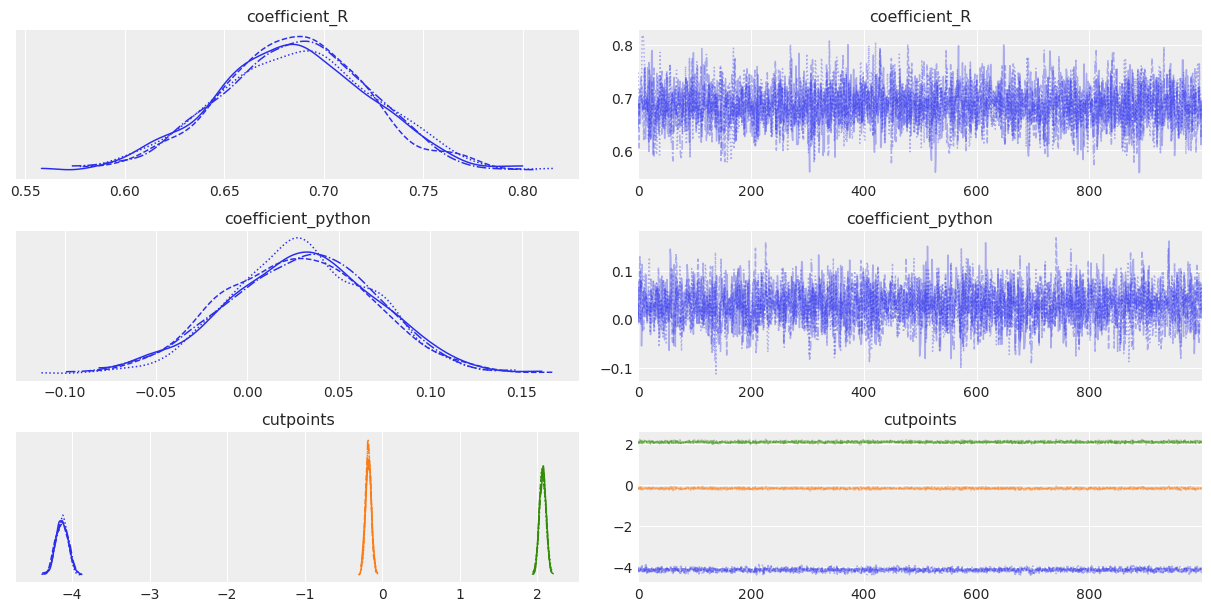

In [108]:
az.plot_trace(az.from_numpyro(mcmc), var_names=["~probs"]);

## Posterior Predictive

In [109]:
post_pred = numpyro.infer.Predictive(ordered_logistic_regression, mcmc.get_samples())
post_predictions = post_pred(
    jax.random.PRNGKey(93),
    python=train['python'].to_numpy(),
    R=train['R'].to_numpy(),
    n_responses=4,
)

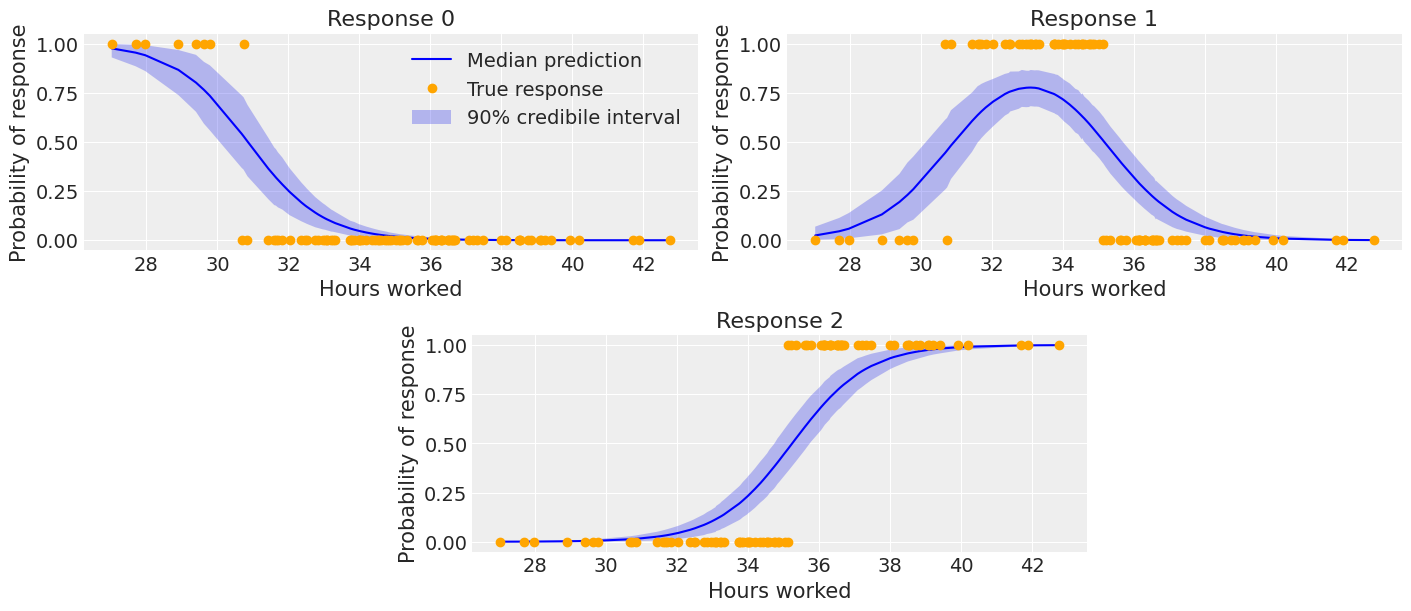

In [41]:
fig = plt.figure(figsize=(14, 6))
idx = train["hours_worked"].sort_values().index

gs = gridspec.GridSpec(4, 4, figure=fig)
ax = []
ax.append(fig.add_subplot(gs[:2, :2]))
ax.append(fig.add_subplot(gs[:2, 2:], sharey=ax[0]))
ax.append(fig.add_subplot(gs[2:, 1:3]))

for response in (0, 1, 2):
    ax[response].fill_between(
        train.loc[idx, "hours_worked"],
        *numpyro.diagnostics.hpdi(
            post_predictions["probs"][:, idx.to_numpy(), response]
        ),
        alpha=0.3,
        label="90% credibile interval",
    )
    ax[response].plot(
        train.loc[idx, "hours_worked"],
        jnp.median(post_predictions["probs"][:, idx.to_numpy(), response], axis=0),
        color="blue",
        label="Median prediction",
    )
    true = pd.concat(
        [pd.get_dummies(train["response"], prefix="response"), train["hours_worked"]],
        axis=1,
    ).loc[
        idx
    ]  # .plot.scatter(x="hours_worked", y=f"response_{response}", ax=ax[response], c='orange', label=f'True response of {response}')
    ax[response].plot(
        train.loc[idx, "hours_worked"],
        true[f"response_{response}"],
        "o",
        c="orange",
        label=f"True response",
    )
    ax[response].set_xlabel("Hours worked")
    ax[response].set_ylabel("Probability of response")
    if response == 0:
        ax[response].legend()
    ax[response].set_title(f"Response {response}")

## But wait!

I said at the start that we had a test set. Let's check our predictions on it.

In [42]:
post_pred = numpyro.infer.Predictive(ordered_logistic_regression, mcmc.get_samples())
post_predictions = post_pred(
    jax.random.PRNGKey(93),
    hours_worked_scaled=test["hours_worked_scaled"].to_numpy(),
    n_responses=3,
)

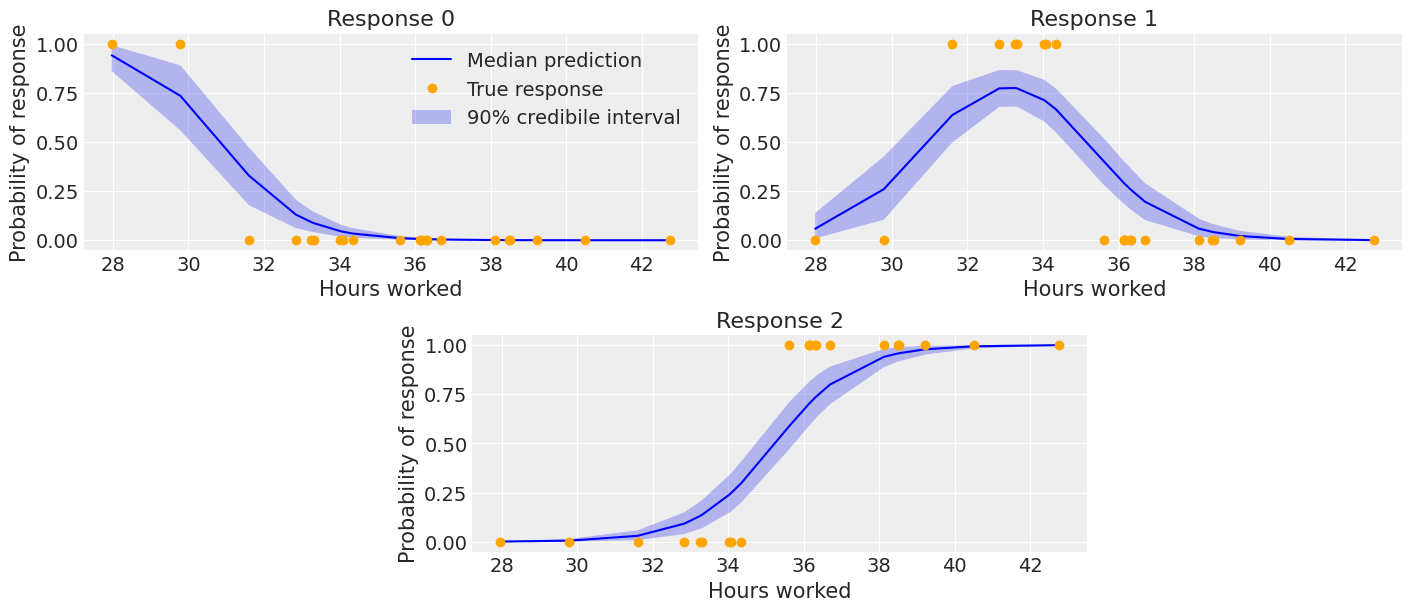

In [43]:
fig = plt.figure(figsize=(14, 6))
idx = test["hours_worked"].sort_values().index

gs = gridspec.GridSpec(4, 4, figure=fig)
ax = []
ax.append(fig.add_subplot(gs[:2, :2]))
ax.append(fig.add_subplot(gs[:2, 2:], sharey=ax[0]))
ax.append(fig.add_subplot(gs[2:, 1:3]))

for response in test["response"].unique():
    ax[response].fill_between(
        test.loc[idx, "hours_worked"],
        *numpyro.diagnostics.hpdi(
            post_predictions["probs"][:, idx.to_numpy(), response]
        ),
        alpha=0.3,
        label="90% credibile interval",
    )
    ax[response].plot(
        test.loc[idx, "hours_worked"],
        jnp.median(post_predictions["probs"][:, idx.to_numpy(), response], axis=0),
        color="blue",
        label="Median prediction",
    )
    true = pd.concat(
        [pd.get_dummies(test["response"], prefix="response"), test["hours_worked"]],
        axis=1,
    ).loc[idx]
    ax[response].plot(
        test.loc[idx, "hours_worked"],
        true[f"response_{response}"],
        "o",
        c="orange",
        label=f"True response",
    )
    ax[response].set_xlabel("Hours worked")
    ax[response].set_ylabel("Probability of response")
    if response == 0:
        ax[response].legend()
    ax[response].set_title(f"Response {response}")

## Conclusion

- Use when your outcome has ordered categories (e.g. survey response)
- NumPyro has the convenient `OrderedLogistic` class available

## Resources

Statistical Rethinking - Richard McElreath

Betancourt's case studies

Learning Bayesian Statistics podcast - Alex Andorra